In [1]:

import pandas as pd
import matplotlib.pyplot as plt

from user import User
from average import Average


# Seed value
# Apparently you may use different seed values at each stage
SEED = 0

import os


import time
import numpy as np
import tensorflow as tf
import random
from tensorflow import keras
from sklearn.model_selection import train_test_split

# # Set `PYTHONHASHSEED` environment variable at a fixed value
os.environ['PYTHONHASHSEED']=str(SEED)


# # The below is necessary for starting Numpy generated random numbers
# # in a well-defined initial state.

np.random.seed(SEED)

# # The below is necessary for starting core Python generated random numbers
# # in a well-defined state.

random.seed(SEED)

# # Force TensorFlow to use single thread.
# # Multiple threads are a potential source of non-reproducible results.
# # For further details, see: https://stackoverflow.com/questions/42022950/

# session_conf = tf.ConfigProto(intra_op_parallelism_threads=1,
#                               inter_op_parallelism_threads=1)


# # The below tf.set_random_seed() will make random number generation
# # in the TensorFlow backend have a well-defined initial state.
# # For further details, see:
# # https://www.tensorflow.org/api_docs/python/tf/set_random_seed

tf.set_random_seed(SEED)

# sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)
# keras.backend.set_session(sess)
    
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:

def read_file(file):
    """
    return 2d df after imputing with 0s"""

    # read data
    df = pd.read_csv(file)

    # replace the question marks with NaN and then change data type to float 32
    df.replace(["?"],np.nan, inplace = True)
    df = df.astype(np.float32)

    # imputation
    df.fillna(0,inplace=True) # fill nulls with 0
    return df


def split_dataframe(df, for_user = None, val_size = 0.25, test_size =  0.75, seed = None):
    """
    split the dataframe into train, validation and test splits based on the same seed
    """
    # split into train, validation and test data using sklearn and return dfs for each
    if for_user!=None:
        df = df[df["User"] == for_user]
    if df.shape[0] == 0:
        # if no data for the user, then return 9 empty dfs as per the api
        # print(f"Dataframe for user {user} is of shape {df.shape}, no data. Skipping...")
        df = pd.DataFrame()
        return (df for _ in range(9))
    df_train, df_test = train_test_split(df,
                                         test_size = test_size,
                                         random_state = seed)

    df_train, df_val  = train_test_split(df_train,
                                         test_size = val_size,
                                         random_state = seed)

    # store class and user information (in order)
    df_val_class, df_train_class, df_test_class = df_val["Class"], df_train["Class"], df_test["Class"]
    df_val_user,  df_train_user,  df_test_user  = df_val["User"],  df_train["User"],  df_test["User"]

    # drop the class and user identifier columns from data frame
    df_val   = df_val.  drop(df_train.columns[[0,1]], axis=1)
    df_train = df_train.drop(df_train.columns[[0,1]], axis=1)
    df_test  = df_test. drop(df_test. columns[[0,1]], axis=1)

    return df_val, df_val_class,  df_val_user,\
        df_test, df_test_class, df_test_user, \
        df_train, df_train_class, df_train_user

In [3]:
def init_model(init_seed=None):
    """
    initialise and return a model 
    """

    model = keras.Sequential([
        keras.layers.Flatten(),
#         keras.layers.Dense(2048, activation='relu',
#             kernel_initializer=keras.initializers.glorot_uniform(seed=init_seed)),
#         keras.layers.Dense(1024, activation='relu',
#             kernel_initializer=keras.initializers.glorot_uniform(seed=init_seed)),
#         keras.layers.Dense(128, activation='relu',
#             kernel_initializer=keras.initializers.glorot_uniform(seed=init_seed)),
        keras.layers.Dense(32, activation='relu',
            kernel_initializer=keras.initializers.glorot_uniform(seed=init_seed)),
        keras.layers.Dense(6, activation='softmax',
            kernel_initializer=keras.initializers.glorot_uniform(seed=init_seed))
    ])

    model.compile(
        optimizer = 'adam',
        loss = 'sparse_categorical_crossentropy',
        metrics = ['accuracy']
    )

    return model
def init_users(df, averaging_method, seed = None):
    """
    initialise users based on dataframe given and assign random averaging method
    to them based on the list passed in.
    returns a dictionary of users(key: user object) and a global user object
    """    
    print("Initialising User instances...")
    users = dict()
    num_users = df["User"].nunique()

    for user_id in range(-1,num_users):

        i = user_id

        if user_id < 0: # for global user with id -1
            user_id = None

        df_val, df_val_class,  df_val_user,\
        df_test, df_test_class, df_test_user,\
        df_train, df_train_class, df_train_user = split_dataframe(df, for_user=user_id, seed = seed)

        user_id = i

        if df_train.shape[0]==0:
            print(f"User {user_id} has no data, no instance created...")
            continue

        model = init_model(init_seed = seed)
        
# 
        option = np.random.randint(0,len(averaging_methods))
#         print(user_id, averaging_methods[option])
#         option = 0
        users[user_id] = User(user_id=user_id,
                          averaging_method = averaging_methods[option],
                          model = model,
                          train_class = df_train_class,
                          train_data = df_train,
                          val_class = df_val_class,
                          val_data = df_val,
                          test_class = df_test_class,
                          test_data = df_test)

    global_user = users.pop(-1)
    global_user.set_averaging_method(averaging_methods[0])
    print(f"{len(users.keys())} User instances and a global user created!")
    return users, global_user

In [4]:
def train_users(users, epochs,
                new_weights = None,
                train_user_verbose_evaluate = 0,
                train_user_verbose_fit = False,
                verbose = True):
    """
    this method is used to train all users on the passed in epochs value
    """
    
    for user in users.values():
        # if user.get_id() < 0:
        #     continue

        if verbose:
            message = f"User {user.get_id()} being trained on the model..."
            print(message)

        user.train(
            epochs = epochs,
            weights = new_weights, # if none, then wont be updated
            verbose_fit = train_user_verbose_fit,
            verbose_evaluate = train_user_verbose_evaluate
        )

        if verbose:
            message = f"User {user.get_id()} done!"
            print(message)

    return



def train_fed(epochs, rounds, users,
              verbose = True,
              strat = "central",
              train_user_verbose = False,
              train_user_verbose_evaluate = False,
              train_user_verbose_fit = False,
              averaging_method = Average.all,
             averaging_pre = False,
             averaging_post = False,
             averaging_loss = False,
             averaging_accuracy = False):
    """
    this function trains a federation of users using 'strat' stratergy
    central or personalised
    
    central is where all the users send data to a server and the server
    sends back new weights
    
    personalised is where all the users are sent each others data
    and the user tests how their own test data performs on everyone elses models.
    Based on their policy, they then decide what way to average the data
    """

    new_weights = None
    for i in range(rounds):
        if verbose:
            message = f"{'*'*32} {i:^4} {'*'*32}"
            print(message)

        train_users(users, epochs = EPOCHS,
                   new_weights = new_weights,
                   verbose = train_user_verbose,
                   train_user_verbose_evaluate = train_user_verbose_evaluate,
                   train_user_verbose_fit = train_user_verbose_fit)
        if strat == "central":
             new_weights = averaging_method(users, 
                                  pre = averaging_pre,
                                  post = averaging_post, 
                                  accuracy = averaging_accuracy, 
                                  loss = averaging_loss)
#             new_weights = User.static_average_weights(users, method = averaging_method, 
#                                       pre = averaging_pre,
#                                       post = averaging_post, 
#                                       accuracy = averaging_accuracy, 
#                                       loss = averaging_loss)
        elif strat == "personalised":
            for user in users.values():
                user.average_weights(users,
                                    pre = averaging_pre,
                                      post = averaging_post, 
                                      accuracy = averaging_accuracy, 
                                      loss = averaging_loss)
            
        if verbose:
            message = f"{'*'*32} {'DONE':^4} {'*'*32}"
            print(message)
    return


In [5]:
def draw_graphs(user, loss = True, accuracy = True):
    # this is from the book 74,75
    # history = model.fit(...)
    """
    this function draws the history graph for the user from the most
    recent fit performed on it
    """

    history = user.get_history()
    history_dict = history.history

    loss_values = history_dict['loss']
    val_loss_values = history_dict['val_loss']
    acc_values = history_dict['acc']
    val_acc_values = history_dict['val_acc']
    epochs = range(1, len(loss_values) + 1)
    plt.xlabel('Epochs')

    if loss:
        plt.plot(epochs, acc_values, 'b', label='Training acc')
        plt.plot(epochs, val_acc_values, 'r', label='Validation acc')
        plt.title('Training and validation accuracy')
        plt.ylabel('Accuracy')
        plt.legend()
        plt.show()
        plt.clf()
    if accuracy:
        plt.plot(epochs, loss_values, 'b', label='Training loss')
        plt.plot(epochs, val_loss_values, 'r', label='Validation loss')
        plt.title('Training and validation loss')
        plt.ylabel('Loss')
        plt.legend()
        plt.show()
        plt.clf()


def _plot_with_fill(df, x_axis, position, metric, color, std_dev_fill, min_max_fill):
    """
    private function used to plot the average line and provide a fill
    based on the fill strategy passed in
    """

    position_label = f"{position}-fit"
    position_df = df[df["Position"]==f"{position}"]
    avg = position_df["Average"]
    plt.plot(x_axis, avg, color, linewidth = 1, label = f"{position_label} {metric}")

    if std_dev_fill:
        std_dev = position_df["Standard Deviation"]
        plt.fill_between(x_axis, 
                         avg - std_dev, 
                         avg + std_dev, 
                         alpha=0.08, color = color)
    elif min_max_fill:
        mini = position_df["Minimum"]
        maxi = position_df["Maximum"]
        plt.fill_between(x_axis,
                         maxi, 
                         avg, 
                         alpha=0.08, color = color)
        plt.fill_between(x_axis,
                         avg, 
                         mini, 
                             alpha=0.08, color = color)

def _userwise_data(user, 
                     ignore_first_n = 0, 
                      loss = False, 
                      accuracy = False, 
                      post = False, pre = False):
    """
    private function used to provide average, std_dev, min, max and final values
    of the defined metric and position which are passed in
    """

    user_data = user.get_data(ignore_first_n = ignore_first_n, 
                                      loss = loss, 
                                      accuracy = accuracy, 
                                      pre= pre,
                                     post = post)
    avg = np.average(user_data)
    std_dev = np.std(user_data)
    mini = np.amin(user_data)
    maxi = np.amax(user_data)
    final = user_data[-1]
    return (user_data,avg, std_dev, mini, maxi,final)        

def userwise_stats_df(users,ignore_first_n = 0, 
                      loss = False, 
                      accuracy = False, 
                      post = False, pre = False):
    """
    returns a dataframe of data obtained from userwise_data based on position and metrics with
    cols ["Position", "User", "Average", "Standard Deviation", "Minimum", "Maximum", "Final Value"]
    """

    cols = ["Position", "User", "Average", "Standard Deviation", "Minimum", "Maximum", "Final Value"]
    df = pd.DataFrame(columns = cols)
    df_index = 0    
    for i, user in users.items():
        if post:
            user_data,avg, std_dev, mini, maxi,final = \
              _userwise_data(user, 
                ignore_first_n = ignore_first_n, 
                loss = loss, 
                accuracy = accuracy, 
                post = post)

            df.loc[df_index] = ["Post", i, avg, std_dev, mini, maxi, final]
            df_index +=1
        if pre:
            user_data,avg, std_dev, mini, maxi,final = \
                   _userwise_data(user, 
                     ignore_first_n = ignore_first_n, 
                          loss = loss, 
                          accuracy = accuracy, 
                          pre = pre)       
            df.loc[df_index] = ["Pre", i, avg, std_dev, mini, maxi, final]

            df_index +=1 
    return df

def avg_user_stats(users, std_dev_fill = False, min_max_fill = False,
                        loss = False, accuracy = False, pre = True, post = True,
                        ignore_first_n = 0, save_as = None, final_values = False):
    
    """
    prints graphs based on per user data and optionally returns the final metric 
    values for them as well. Use save_as to save the graph plotted and can ignore_first_n
    round data in the graphin
    """

    
    if (loss == accuracy) or (std_dev_fill and min_max_fill):
        print("Please select one from accuracy or loss and one or nonefrom std_dev_fill or min_max_fill")
        return None
    # get the data for the prints ready
    metric = "Accuracy"
    if loss:
        metric = "Loss"
    
    fill_type = None
    if std_dev_fill:
        fill_type = "std_dev_fill"
    elif min_max_fill:
        fill_type = "min_max_fill"
    
    
    # data collection into df
    df = userwise_stats_df(users, 
                     ignore_first_n = ignore_first_n, 
                          loss = loss, 
                          accuracy = accuracy, 
                        post = post , pre = pre)
            
    user_ids = list(users.keys())
    # plot here and then fill here
    
    if pre:
        if final_values:
            _print_finals(df, position = "Pre", metric= metric)
            
        _plot_with_fill(df, x_axis = user_ids,
                        position = "Pre",
                        metric = metric,
                        color = "r",
                        min_max_fill = min_max_fill, 
                        std_dev_fill = std_dev_fill)
    
    if post:
        if final_values:
            _print_finals(df, position = "Post", metric = metric)
        
        _plot_with_fill(df, x_axis = user_ids,
                        position = "Post",
                        metric = metric,
                        color = "b",
                        min_max_fill = min_max_fill, 
                        std_dev_fill = std_dev_fill)

    
    plt.xlabel("Users")
    plt.ylabel(f"{metric}")
    plt.title(f"Average {metric} per User with fill type: {fill_type}")
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    if save_as:
        plt.savefig(save_as)
    plt.show()
    plt.clf()
    return df


def _print_finals(df, position, metric):
    """
    prints the final averaged value for metric and position defined
    """
    finals =df[df["Position"]==f"{position}"]
    finals = finals[["User", "Final Value"]]
    print(f"Final {metric} for {position}-fit data")
    print(finals)
    print(f"Averaged: {finals['Final Value'].mean()}\n")


def _roundwise_data(users, 
                     ignore_first_n = 0, 
                      loss = False, 
                      accuracy = False, 
                      post = False, pre = False):
    """
    returns a tuple of data for based on rounds containing all data, rounds, 
    average, standard deviation, min value and max value per 
    """
    user_data = []
    for i, user in users.items():
        user_data_temp = user.get_data(ignore_first_n = ignore_first_n, 
                                  loss = loss, 
                                  accuracy = accuracy, 
                                  post = post, pre = pre)
        user_data.append(user_data_temp)
    user_data = np.asarray(user_data)
    rounds = len(user_data[0])
    avg = np.average(user_data, axis = 0)
    std_dev = np.std(user_data,  axis = 0)
    mini = np.amin(user_data, axis = 0)
    maxi = np.amax(user_data, axis = 0)
    return (user_data,rounds,avg, std_dev, mini, maxi)        

def roundwise_stats_df(users,ignore_first_n = 0, 
                      loss = False, 
                      accuracy = False, 
                      post = False, pre = False):
    
    """
    returns a data frame of the cols
    ["Position", "Round", "Average", "Standard Deviation", "Minimum", "Maximum"]
    based on data recieved from roundwise_data catered to position and metric passed in
    """
    
    cols = ["Position", "Round", "Average", "Standard Deviation", "Minimum", "Maximum"]
    df = pd.DataFrame(columns = cols)
        
    # collect user metric values into a numpy array
    # of shape (number of users, number of rounds)
    # and calculate roundwise average across all users returning an
    # array for the average of the round across all users
    if post:
        user_data_post,rounds,post_avg, post_std_dev, post_mini, post_maxi = \
                          _roundwise_data(users,
                          ignore_first_n = ignore_first_n, 
                          loss = loss, 
                          accuracy = accuracy, 
                          post = post)
    if pre:
        user_data_pre,rounds,pre_avg, pre_std_dev, pre_mini, pre_maxi = \
                          _roundwise_data(users,
                          ignore_first_n = ignore_first_n, 
                          loss = loss, 
                          accuracy = accuracy, 
                          pre = pre)
        
    # the arrays consisting of averages for all rounds, across n users
    # is then put into a dataframe for roundwise stats required for plotting
    
    rounds = [i+ignore_first_n for i in range(rounds)]
    df_index = 0
    for rnd in rounds:
        rnd -= ignore_first_n
        if pre:
            df.loc[df_index] = ["Pre", rnd+ignore_first_n, 
                                pre_avg[rnd], pre_std_dev[rnd], 
                                pre_mini[rnd], pre_maxi[rnd]]
            df_index +=1
        
        if post:
            df.loc[df_index] = ["Post", rnd+ignore_first_n, 
                                post_avg[rnd], post_std_dev[rnd], 
                                post_mini[rnd], post_maxi[rnd]]
            df_index +=1    
    return (df, rounds)


def avg_round_stats(users, std_dev_fill = False, min_max_fill = False,
                        loss = False, accuracy = False, pre = True, post = True,
                        ignore_first_n = 0, save_as = None, final_values = False):
    
    
    """
    prints graphs based on per round data and optionally returns the final metric 
    values for them as well. Use save_as to save the graph plotted and can ignore_first_n
    round data in the graphin
    """

    if (loss == accuracy) or (std_dev_fill and min_max_fill):
        print("Please select one from accuracy or loss and one or nonefrom std_dev_fill or min_max_fill")
        return None
    # get the data for the prints ready
    metric = "Accuracy"
    if loss:
        metric = "Loss"
    
    fill_type = None
    if std_dev_fill:
        fill_type = "std_dev_fill"
    elif min_max_fill:
        fill_type = "min_max_fill"
    
    
    # data collection into df
    df, rounds = roundwise_stats_df(users, 
                     ignore_first_n = ignore_first_n, 
                          loss = loss, 
                          accuracy = accuracy, 
                        post = post , pre = pre)
    # plot here and then fill here
    if pre:
        if final_values:
            print(f"Final values for Pre-fit {metric}")
            finals = df[df["Position"]=="Pre"].iloc[-1]
            print(finals)

        _plot_with_fill(df, x_axis = rounds,
                        position = "Pre",
                        metric = metric,
                        color = "r",
                        min_max_fill = min_max_fill, 
                        std_dev_fill = std_dev_fill)
    
    if post:
        if final_values:
            print(f"Final values for Post-fit {metric}")
            finals = df[df["Position"]=="Post"].iloc[-1]
            print(finals,end="\n\n")
        _plot_with_fill(df, x_axis = rounds,
                        position = "Post",
                        metric = metric,
                        color = "b",
                        min_max_fill = min_max_fill, 
                        std_dev_fill = std_dev_fill)

    
    
    plt.xlabel("Rounds")
    plt.ylabel(f"{metric}")
    plt.title(f"Average {metric} per Round with fill type: {fill_type}")
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    if save_as:
        plt.savefig(save_as)
    plt.show()
    plt.clf()
    return df


In [6]:
#### algorithm:
df = read_file("../dataset/allUsers.lcl.csv")
df_unshuffled = df
# shuffle the records
# df = df.sample(frac = 1)

# reading this number of times can lead to the dataset 
# being rearranged every time
# so use a seed here or something else to ensure every 
# single time is the same
# even though currently the np random seed is set,
# but it probably selects a different seed everytime
df = df.take(np.random.permutation(df.shape[0]))
df.reset_index(drop = True, inplace = True)

averaging_methods = ["all","std_dev","weighed_avg"]

In [11]:
DEVICE = '/cpu:0'
ROUNDS = 1
EPOCHS = 16 # 16 is good

# start = time.time()

with tf.device(DEVICE):
    
#     users_weighted_avg, global_user = init_users(df, averaging_methods, SEED) # return a dictionary of users with data
#     train_fed(users = users_weighted_avg, rounds = ROUNDS,
#               epochs = EPOCHS,
#               strat = "central",
#               train_user_verbose = False,
#               train_user_verbose_evaluate = False,
#               train_user_verbose_fit = False,
#               averaging_method =  Average.weighted_avg,
#              averaging_post = True,
#              averaging_accuracy = True)
    
#     users_std_dev, global_user = init_users(df, averaging_methods, SEED) # return a dictionary of users with data
#     train_fed(users = users_std_dev, rounds = ROUNDS,
#               epochs = EPOCHS,
#               strat = "central",

#               train_user_verbose = False,
#               train_user_verbose_evaluate = False,
#               train_user_verbose_fit = False,
#               averaging_method =  Average.std_dev,
#              averaging_post = True,
#              averaging_accuracy = True)
    

    users_all, global_user = init_users(df, averaging_methods, SEED) # return a dictionary of users with data
    train_fed(users = users_all, rounds = ROUNDS,
              epochs = EPOCHS,
              strat = "central",
              train_user_verbose = False,
              train_user_verbose_evaluate = False,
              train_user_verbose_fit = False,
              averaging_method = Average.all,
             averaging_post = True,
             averaging_accuracy = True)
    users_all_2, global_user = init_users(df, averaging_methods, SEED) # return a dictionary of users with data
    train_fed(users = users_all_2, rounds = ROUNDS,
              epochs = EPOCHS,
              strat = "central",
              train_user_verbose = False,
              train_user_verbose_evaluate = False,
              train_user_verbose_fit = False,
              averaging_method = Average.all,
             averaging_post = True,
             averaging_accuracy = True)


#     inter = time.time()

#     users, global_user = init_users(df) # return a dictionary of users with data

#     print("Global user training and validation")
#     global_user.train(epochs = EPOCHS*ROUNDS,
#        verbose_fit = True,
#        verbose_evaluate = True,
#     )
#     draw_graphs(global_user)
    
#     done = time.time()

Initialising User instances...
User 3 has no data, no instance created...
13 User instances and a global user created!
********************************  0   ********************************
******************************** DONE ********************************
Initialising User instances...
User 3 has no data, no instance created...
13 User instances and a global user created!
********************************  0   ********************************
******************************** DONE ********************************


For all
Final values for Pre-fit Accuracy
Position                    Pre
Round                         0
Average                0.111486
Standard Deviation    0.0417254
Minimum               0.0366322
Maximum                0.178947
Name: 0, dtype: object
Final values for Post-fit Accuracy
Position                  Post
Round                        0
Average               0.852982
Standard Deviation    0.172599
Minimum               0.349593
Maximum               0.989016
Name: 1, dtype: object



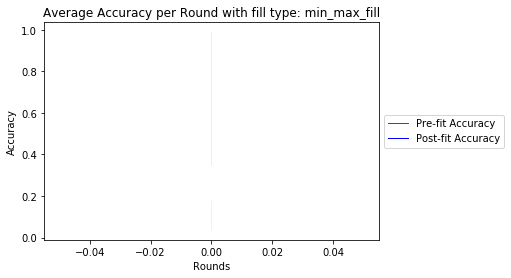

Final values for Pre-fit Accuracy
Position                    Pre
Round                         0
Average                0.111486
Standard Deviation    0.0417254
Minimum               0.0366322
Maximum                0.178947
Name: 0, dtype: object
Final values for Post-fit Accuracy
Position                  Post
Round                        0
Average               0.852982
Standard Deviation    0.172599
Minimum               0.349593
Maximum               0.989016
Name: 1, dtype: object



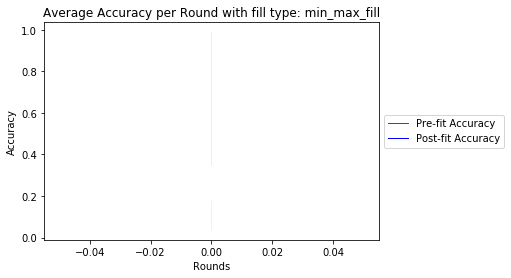

<Figure size 432x288 with 0 Axes>

In [12]:
ignore_first_n = 0
final_values = True

print("For all")


df_avg_round_stats_acc = avg_round_stats(users_all, 
                                         ignore_first_n = ignore_first_n, 
                                         min_max_fill = True, 
                                         accuracy = True,
                                         final_values = final_values)



df_avg_round_stats_acc = avg_round_stats(users_all_2, 
                                         ignore_first_n = ignore_first_n, 
                                         min_max_fill = True, 
                                         accuracy = True,
                                         final_values = final_values)
0.989016

For all
Final Accuracy for Pre-fit data
   User  Final Value
1     0     0.103138
3     1     0.088751
5     2     0.036632
7     4     0.178947
9     5     0.146252
11    6     0.088943
13    7     0.102981
15    8     0.146213
17    9     0.156803
19   10     0.105850
21   11     0.107674
23   12     0.038093
25   13     0.149047
Averaged: 0.11148642290097016

Final Accuracy for Post-fit data
   User  Final Value
0     0     0.880212
2     1     0.921707
4     2     0.938257
6     4     0.592982
8     5     0.933664
10    6     0.867804
12    7     0.349593
14    8     0.903308
16    9     0.882313
18   10     0.937187
20   11     0.960139
22   12     0.932584
24   13     0.989016
Averaged: 0.8529820786072657



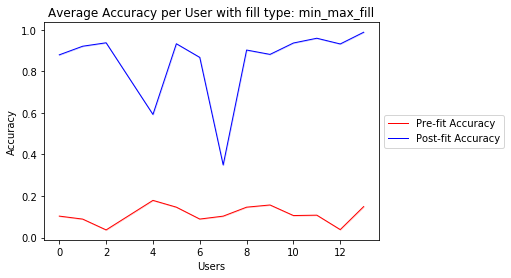

Final values for Pre-fit Accuracy
Position                    Pre
Round                         0
Average                0.111486
Standard Deviation    0.0417254
Minimum               0.0366322
Maximum                0.178947
Name: 0, dtype: object
Final values for Post-fit Accuracy
Position                  Post
Round                        0
Average               0.852982
Standard Deviation    0.172599
Minimum               0.349593
Maximum               0.989016
Name: 1, dtype: object



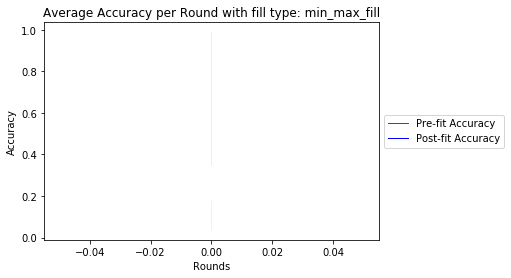

For acc > avg-std


NameError: name 'users_std_dev' is not defined

<Figure size 432x288 with 0 Axes>

In [10]:
# """
ignore_first_n = 0
final_values = True

print("For all")

df_avg_user_stats_acc = avg_user_stats(users_all, 
                                       ignore_first_n = ignore_first_n, 
                                       min_max_fill = True, 
                                       accuracy = True,
                                      final_values = final_values)


df_avg_round_stats_acc = avg_round_stats(users_all, 
                                         ignore_first_n = ignore_first_n, 
                                         min_max_fill = True, 
                                         accuracy = True,
                                         final_values = final_values)

print("For acc > avg-std")
df_avg_user_stats_acc = avg_user_stats(users_std_dev, 
                                       ignore_first_n = ignore_first_n, 
                                       min_max_fill = True, 
                                       accuracy = True,
                                      final_values = final_values)

df_avg_round_stats_acc = avg_round_stats(users_std_dev, 
                                         ignore_first_n = ignore_first_n, 
                                     min_max_fill = True, 
                                         accuracy = True,
                                        final_values = final_values)


print("For weight * weighted_avg")

df_avg_user_stats_acc = avg_user_stats(users_weighted_avg, 
                                       ignore_first_n = ignore_first_n, 
                                       min_max_fill = True, 
                                       accuracy = True,
                                      final_values = final_values)


df_avg_round_stats_acc = avg_round_stats(users_weighted_avg, 
                                         ignore_first_n = ignore_first_n, 
                                         min_max_fill = True, 
                                         accuracy = True,
                                         final_values = final_values)


# print(df_avg_round_stats_acc)
# """


In [ ]:
users_all[0].get_weights()

In [ ]:
users_all_2[0].get_weights()